In [1]:
using JuMP
using Ipopt
using DataFrames
import XLSX
using CSV
using Plots
gr(fmt=:png);

abstract type Model end
struct BEM <: Model end
struct Migration <: Model end

run = BEM();

In [18]:
df2 = dropmissing(DataFrame(XLSX.readtable("./DATA/R3_data.xlsx", "Sheet1")...))
VolAll = Float64.(df2[:C_t]) ## CATCH DATA
PrAll = Float64.(df2[:pf_MXNiat]) ## PRICE DATA

### New max time
time = df2[:year][1]:0.1:df2[:year][end]; 
years = df2[:year];
ML = df2[:ML];
y_S = map(y-> parse(Float64, y), df2[:y_S]);
tmax = length(years);
(Cmax, CmaxIdx) = findmax(VolAll); # To calculate K. Should probably self reference this.

In [3]:
q = 0.1;
K = Cmax*q; #1208770# <- Laura is hardcoding to this. Cmax*q #

qML = q*((ML-minimum(ML))/(maximum(ML)-minimum(ML)))
KML = Cmax.*qML;


f = 40.0 # l of fuel per trip
m = 5_492_603.58 # cost per unit of transport all boats, MXN/trip
σ = m*f; # fleet cost of transport
c_t = 107291548; # cost of fishing

In [24]:
# Model with free effort (BEM)
model = JuMP.Model(solver = IpoptSolver(print_level=3,max_iter=100000,print_frequency_iter=200,sb="yes"));

@variable(model, 0.0 <= β <= 1.0) # slope of demand-price function
@variable(model, 20_000.0 <= γₘ <= 51_000.0) # maximum demand, t
@variable(model, 0.0 <= g <= 3.2) # population growth rate
@variable(model, 1000.0 <= κ <= 2148.0) # cost of processing, MXNia/t

@variable(model, 0.0 <= E[t=1:tmax] <= 1.0) # fishing effort
@variable(model, p_f[t=1:tmax]) # price for fishers
@variable(model, S[t=1:tmax] >= 0.0) # size of the squid population 18000 , 1200000
@variable(model, C[t=1:tmax]  >= 0.0) # squid catch. Nominally ~10% of S, which comes through from 0.1*... in q
@variable(model, 4_000.0 <= p_m[t=1:tmax] <= 100_000.0) # export/market price

@variable(model, match)

@NLconstraint(model, [t=1:tmax-1], S[t+1] == S[t]+(g*S[t]*(1-(S[t]/K))-C[t]));
@NLconstraint(model, [t=1:tmax], p_m[t] == γₘ*(C[t])^(-β));
@constraint(model, [t=1:tmax], p_f[t] == p_m[t]-κ);
@NLconstraint(model, [t=1:tmax], C[t] == q*E[t]*S[t]);

@NLconstraint(model, match == sum(abs(p_f[t] - PrAll[t])^2+abs(C[t] - VolAll[t])^2 for t in 1:tmax));
@objective(model, Min, match);

In [25]:
solve(model)

Total number of variables............................:       70
                     variables with only lower bounds:       26
                variables with lower and upper bounds:       30
                     variables with only upper bounds:        0
Total number of equality constraints.................:       52
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0


Number of Iterations....: 161

                                   (scaled)                 (unscaled)
Objective...............:   5.7480296317272168e+06    5.7480296317272168e+06
Dual infeasibility......:   3.7471213305741218e-09    3.7471213305741218e-09
Constraint violation....:   1.1641532182693481e-10    1.8626451492309570e-09
Complementarity.........:   2.5245972715903976e-09    2.5245972715903976e-09
Overall NLP 

:Optimal

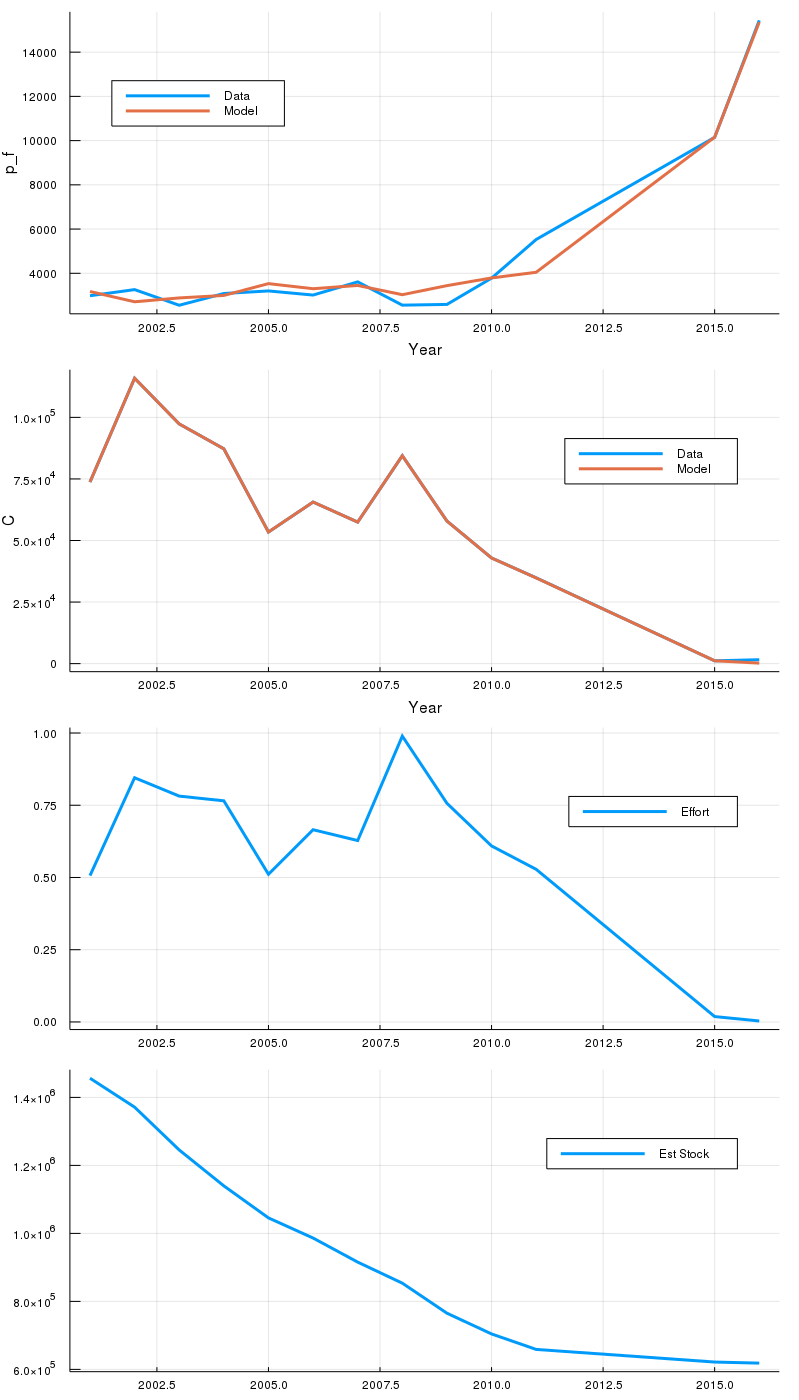

In [26]:
ha = plot(years, PrAll, xlabel="Year", ylabel="p_f", label="Data", legend=:topleft)
plot!(years, getvalue(p_f), label="Model")
hb = plot(years, VolAll, xlabel="Year", ylabel="C", label="Data")
plot!(years, getvalue(C), label="Model")
hc = plot(years, getvalue(E), label = "Effort")
hd = plot(years, getvalue(S), label = "Est Stock")
plot(ha,hb,hc,hd,linewidth=3,layout=(4,1),size=(800,1400))

So we can use this kind of premise I think:

Whilst the BEM model is genrally used as a method for predicting catch & price by maximising effort, here we back track effort based on known catch and price data.

With this method we can obtain optimal parameters for the BEM model, and improve upon its results...

---

The following are free effort optimisations of BLM and MLM

In [4]:
# Model with free effort (BLM)
modeln = JuMP.Model(solver = IpoptSolver(print_level=3,max_iter=100000,print_frequency_iter=200,sb="yes"));

@variable(modeln, 0.0 <= βn <= 1.0) # slope of demand-price function
@variable(modeln, 20_000.0 <= γₘn <= 51_000.0) # maximum demand, t
@variable(modeln, 0.0 <= gn <= 3.2) # population growth rate
@variable(modeln, 1000.0 <= κn <= 2148.0) # cost of processing, MXNia/t

@variable(modeln, 0.0 <= En[t=1:tmax] <= 1.0) # fishing effort
@variable(modeln, p_fn[t=1:tmax]) # price for fishers
@variable(modeln, Sn[t=1:tmax] >= 0.0) # size of the squid population 18000 , 1200000
@variable(modeln, Cn[t=1:tmax]  >= 0.0) # squid catch. Nominally ~10% of S, which comes through from 0.1*... in q
@variable(modeln, 4_000.0 <= p_mn[t=1:tmax] <= 100_000.0) # export/market price

@variable(modeln, matchn)

@NLconstraint(modeln, [t=1:tmax-1], Sn[t+1] == Sn[t]+(gn*Sn[t]*(1-(Sn[t]/KML[t]))-Cn[t]));
@NLconstraint(modeln, [t=1:tmax], p_mn[t] == γₘn*(Cn[t])^(-βn));
@constraint(modeln, [t=1:tmax], p_fn[t] == p_mn[t]-κn);
@NLconstraint(modeln, [t=1:tmax], Cn[t] == qML[t]*En[t]*Sn[t]);

@NLconstraint(modeln, matchn == sum(abs(p_fn[t] - PrAll[t])^2+abs(Cn[t] - VolAll[t])^2 for t in 1:tmax));
@objective(modeln, Min, matchn);

In [5]:
solve(modeln)

Total number of variables............................:       70
                     variables with only lower bounds:       26
                variables with lower and upper bounds:       30
                     variables with only upper bounds:        0
Total number of equality constraints.................:       52
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0


Number of Iterations....: 272

                                   (scaled)                 (unscaled)
Objective...............:   1.4327158928763413e+09    1.4327158928763413e+09
Dual infeasibility......:   1.0231267113064617e+02    1.0231267113064617e+02
Constraint violation....:   2.6244319282783961e-11    2.6244319282783961e-11
Complementarity.........:   9.0909090909090920e-10    9.0909090909090920e-10
Overall NLP 

:Optimal

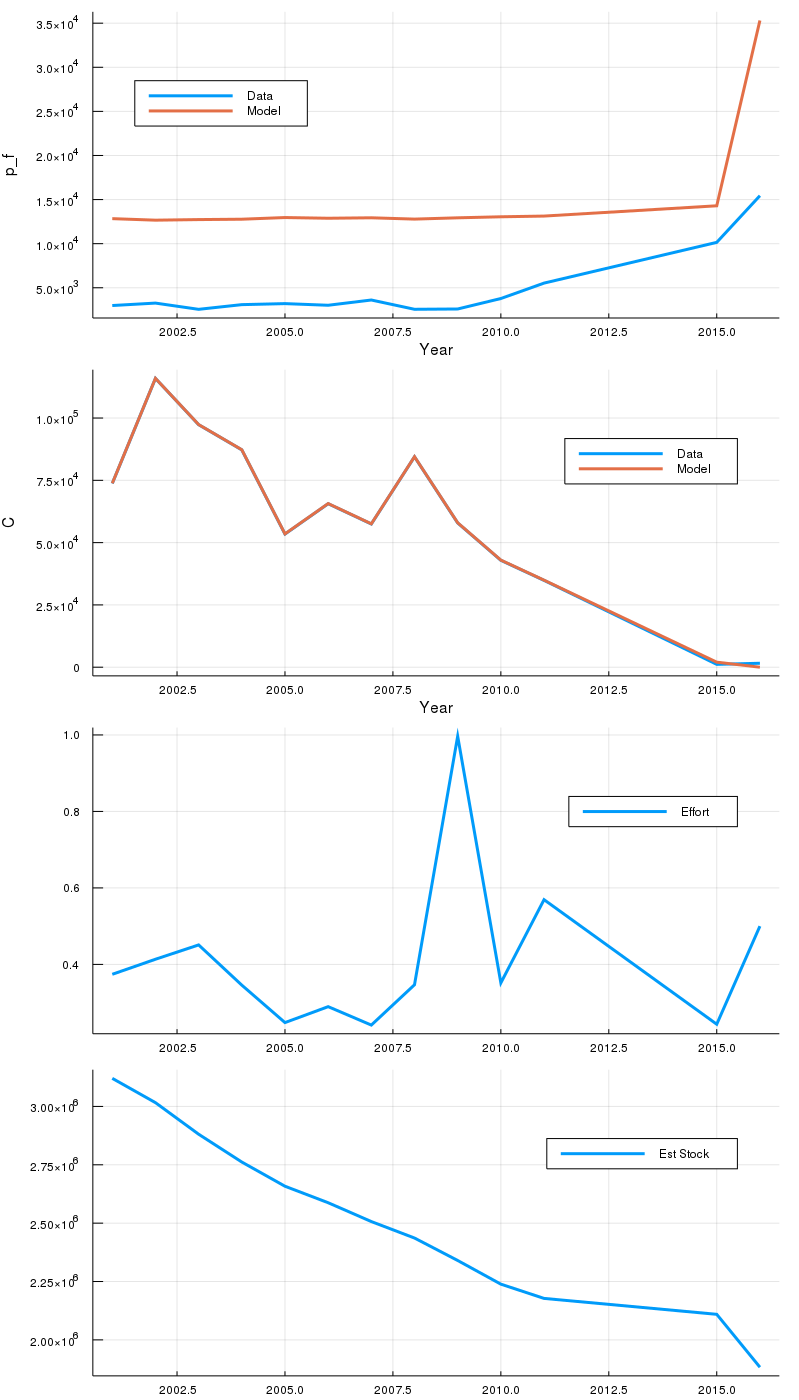

In [7]:
ha = plot(years, PrAll, xlabel="Year", ylabel="p_f", label="Data", legend=:topleft)
plot!(years, getvalue(p_fn), label="Model")
hb = plot(years, VolAll, xlabel="Year", ylabel="C", label="Data")
plot!(years, getvalue(Cn), label="Model")
hc = plot(years, getvalue(En), label = "Effort")
hd = plot(years, getvalue(Sn), label = "Est Stock")
plot(ha,hb,hc,hd,linewidth=3,layout=(4,1),size=(800,1400))

In [20]:
# Model with free effort (MLM)
modele = JuMP.Model(solver = IpoptSolver(print_level=3,max_iter=100000,print_frequency_iter=200,sb="yes"));

@variable(modele, 0.0 <= βe <= 1.0) # slope of demand-price function
@variable(modele, 20_000.0 <= γₘe <= 51_000.0) # maximum demand, t
@variable(modele, 0.0 <= ge <= 3.2) # population growth rate
@variable(modele, 1000.0 <= κe <= 2148.0) # cost of processing, MXNia/t

@variable(modele, 0.0 <= Ee[t=1:tmax] <= 1.0)
@variable(modele, p_fe[t=1:tmax]) # price for fishers
@variable(modele, Se[t=1:tmax] >= 0.0) # size of the squid population 18000 , 1200000
@variable(modele, Ce[t=1:tmax]  >= 0.0) # squid catch. Nominally ~10% of S, which comes through from 0.1*... in q
@variable(modele, 4_000.0 <= p_me[t=1:tmax] <= 100_000.0) # export/market price
@variable(modele, R_tt[t=1:tmax] >= 0)
@variable(modele, p_min[t=1:tmax] >= 0)
@variable(modele, matche)

@NLconstraint(modele, [t=1:tmax-1], Se[t+1] == Se[t]+(ge*Se[t]*(1-(Se[t]/KML[t]))-Ce[t]));
@NLconstraint(modele, [t=1:tmax], p_me[t] == γₘe*(Ce[t])^(-βe));
@NLconstraint(modele, [t=1:tmax], p_min[t] == (c_t*Ee[t])/Ce[t]);
@constraint(modele, [t=1:tmax], p_fe[t] == (p_me[t]-κe)*(1-R_tt[t]) + R_tt[t]*p_min[t]);
@NLconstraint(modele, [t=1:tmax], R_tt[t] == exp(-y_S[t]))
@NLconstraint(modele, [t=1:tmax], Ce[t] == qML[t]*Ee[t]*Se[t]);

@NLconstraint(modele, matche == sum(abs(p_fe[t] - PrAll[t])^2+abs(Ce[t] - VolAll[t])^2 for t in 1:tmax));
@objective(modele, Min, matche);

In [21]:
solve(modele)

Total number of variables............................:       96
                     variables with only lower bounds:       52
                variables with lower and upper bounds:       30
                     variables with only upper bounds:        0
Total number of equality constraints.................:       78
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0


Number of Iterations....: 2962

                                   (scaled)                 (unscaled)
Objective...............:   6.0925551736571907e+10    6.0925551736571907e+10
Dual infeasibility......:   9.9999892738726381e-01    9.9999892738726381e-01
Constraint violation....:   3.6590422702598426e+03    3.6590422702598426e+03
Complementarity.........:   1.1255748459500660e-09    1.1255748459500660e-09
Overall NLP

:Infeasible

In [ ]:
ha = plot(years, PrAll, xlabel="Year", ylabel="p_f", label="Data", legend=:topleft)
plot!(years, getvalue(p_fe), label="Model")
hb = plot(years, VolAll, xlabel="Year", ylabel="C", label="Data")
plot!(years, getvalue(Ce), label="Model")
hc = plot(years, Ee, label = "Effort")
hd = plot(years, getvalue(Se), label = "Est Stock")
plot(ha,hb,hc,hd,linewidth=3,layout=(4,1),size=(800,1400))

As you can see, these are not so good.

---

Let's take the parameters from the BEM run and see how we can extend that.

In [43]:
struct OptimalConstants
    β::Float64
    γ::Float64
    g::Float64
    κ::Float64
    E₀::Float64
    S₀::Float64
end

# Using initial optimal
r = OptimalConstants(getvalue(β), getvalue(γₘ), getvalue(g), getvalue(κ), getvalue(E)[1], getvalue(S)[1]);

# Discrete initially
Ed = Array{Float64}(length(years));
Ed[1] = r.E₀;
Sd = Array{Float64}(length(years));
Sd[1] = r.S₀;
Cd = Array{Float64}(length(years));
Cd[1] = q*r.E₀*r.S₀;
p_md = Array{Float64}(length(years));
p_md[1] = r.γ*Cd[1]^(-r.β);
p_fd = Array{Float64}(length(years));
p_fd[1] = p_md[1]-r.κ;

for t = 1:length(years)-1
    Sd[t+1] = Sd[t]+(r.g*Sd[t]*(1-(Sd[t]/K))-Cd[t]);
    # This equation for effort does not represent our current effort values in the least.
    Ed[t+1] = Ed[t]+(p_fd[t]*Cd[t]-σ*Ed[t]);
    #Pull in the optimal value for Cd instead
    Cd[t+1] = q*getvalue(E)[t+1]*Sd[t+1];
    p_md[t+1] = r.γ*Cd[t+1]^(-r.β);
    p_fd[t+1] = p_md[t+1]-r.κ;
end

println("β: ", r.β, ", γ: ", r.γ, ", g: ", r.g);
println("κ: ", r.κ, ", E₀: ", r.E₀, ", S₀: ", r.S₀);

β: 0.20160038309525063, γ: 51000.0, g: 6.250014184133019e-5
κ: 2148.0, E₀: 0.5063424583268573, S₀: 1.4564012217890888e6


Now, if we use these **optimal BEM parameters**, can we improve the fit by using BLM?

In [50]:
Sl = Array{Float64}(length(years));
Sl[1] = r.S₀;
Cl = Array{Float64}(length(years));
Cl[1] = qML[1]*r.E₀*r.S₀;
p_ml = Array{Float64}(length(years));
p_ml[1] = r.γ*Cl[1]^(-r.β);
p_fl = Array{Float64}(length(years));
p_fl[1] = p_ml[1]-r.κ;

for t = 1:length(years)-1
    Sl[t+1] = Sl[t]+(r.g*Sl[t]*(1-(Sl[t]/KML[t]))-Cl[t]);
    Cl[t+1] = qML[t+1]*getvalue(E)[t+1]*Sl[t+1];
    p_ml[t+1] = r.γ*Cl[t+1]^(-r.β);
    p_fl[t+1] = p_ml[t+1]-r.κ;
end

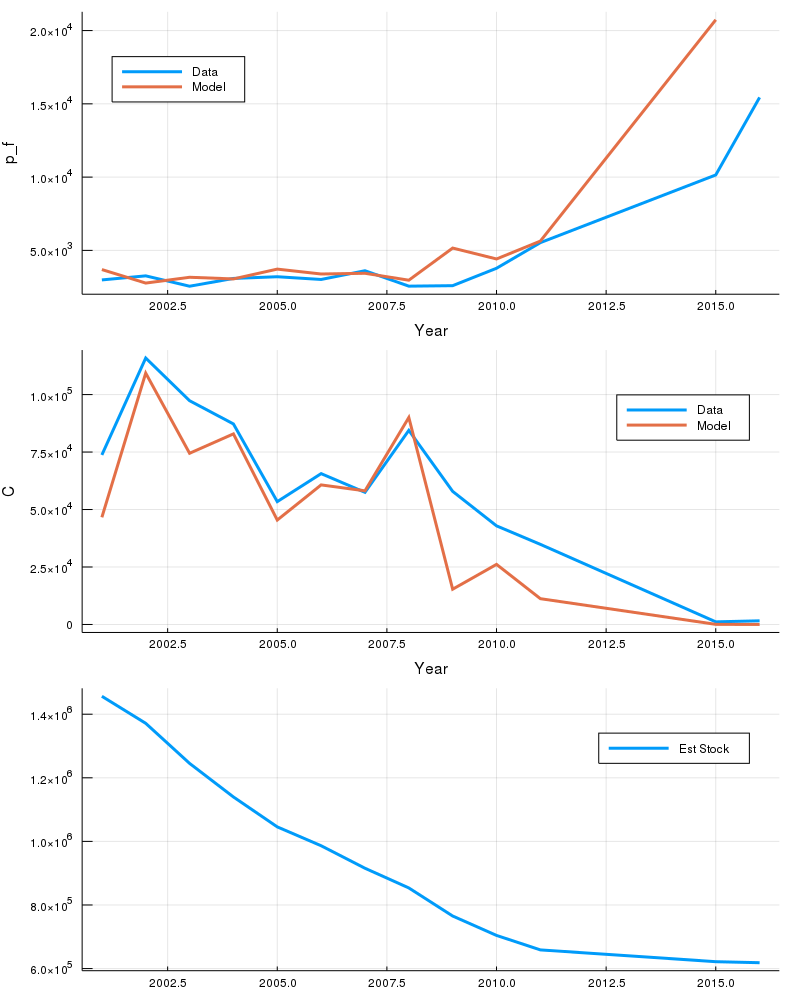

In [51]:
ha = plot(years, PrAll, xlabel="Year", ylabel="p_f", label="Data", legend=:topleft)
plot!(years, p_fl, label="Model")
hb = plot(years, VolAll, xlabel="Year", ylabel="C", label="Data")
plot!(years, Cl, label="Model")
hc = plot(years, Sl, label = "Est Stock")
plot(ha,hb,hd,linewidth=3,layout=(3,1),size=(800,1000))

So this worsens the fit if we keep the BEM effort data. I attempted to just generate effort in proportion to C and S, but this then gives you three unkowns and makes sense for the system to just generate a constant E that fits.

___ 

For completeness, here's the MLM:

In [64]:
Sm = Array{Float64}(length(years));
Sm[1] = r.S₀;
Cm = Array{Float64}(length(years));
Cm[1] = qML[1]*r.E₀*r.S₀;
p_mm = Array{Float64}(length(years));
p_mm[1] = r.γ*Cm[1]^(-r.β);
p_fm = Array{Float64}(length(years));
p_fm[1] = p_mm[1]-r.κ;
p_min = Array{Float64}(length(years));
p_min[1] = (c_t*r.E₀)/Cm[1];

R_tt = exp.(-y_S);

for t = 1:length(years)-1
    Sm[t+1] = Sm[t]+(r.g*Sm[t]*(1-(Sm[t]/KML[t]))-Cm[t]);
    Cm[t+1] = qML[t+1]*getvalue(E)[t+1]*Sm[t+1];
    p_mm[t+1] = r.γ*Cm[t+1]^(-r.β);
    p_min[t] = (c_t*getvalue(E)[t])/Cm[t];
    p_fm[t+1] = (p_mm[t+1]-r.κ)*(1-R_tt[t]) + R_tt[t]*p_min[t];
end


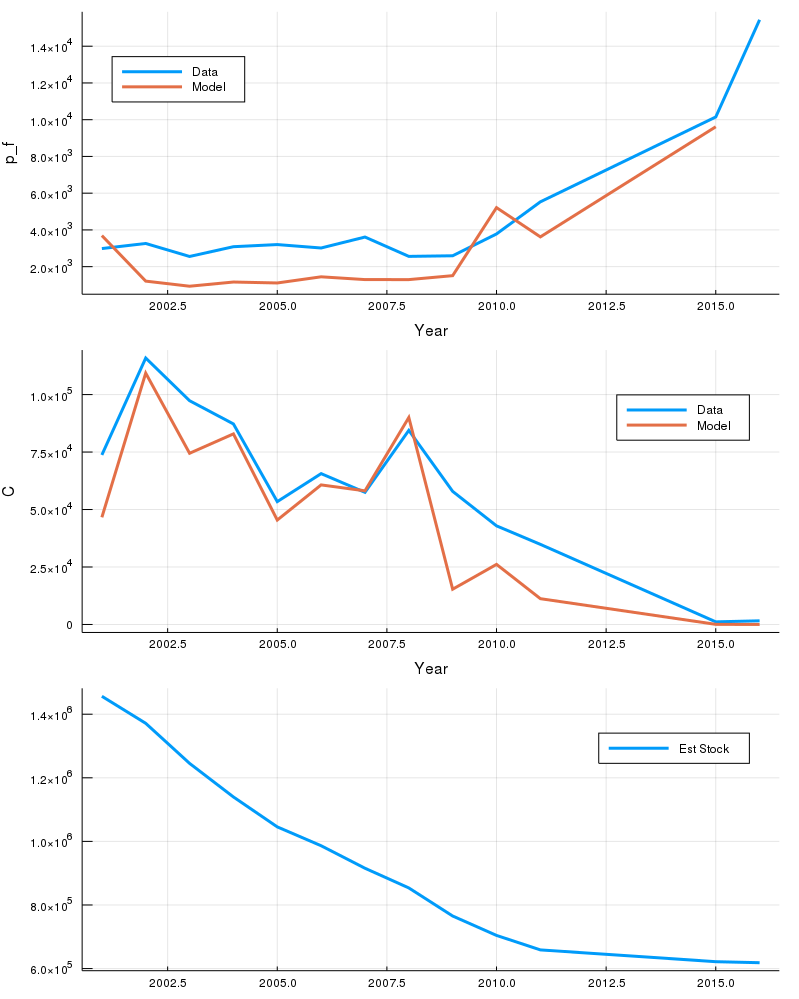

In [65]:
ha = plot(years, PrAll, xlabel="Year", ylabel="p_f", label="Data", legend=:topleft)
plot!(years, p_fm, label="Model")
hb = plot(years, VolAll, xlabel="Year", ylabel="C", label="Data")
plot!(years, Cm, label="Model")
hc = plot(years, Sm, label = "Est Stock")
plot(ha,hb,hd,linewidth=3,layout=(3,1),size=(800,1000))

In terms of this analysis, it seems that BLM still captures the data the best. What happens if you use these parameters in your version of the model?


---

Below here has not been updated just yet...

In [ ]:
using DifferentialEquations
# To work with optimal E
using Interpolations

In [ ]:
# Using initial optimal, trying to use E and failing
#p = [0.190159,  51000.0,  1.15065,  2148.0,  2.07596e5,  2.19704e8,  3.0498];
p = [getvalue(β), getvalue(γₘ), getvalue(g), getvalue(κ), K, σ, q];

function bem(out,du,u,p,t)
  out[1] = p[3]*u[1]*(1-(u[1]/p[5])) - u[3] - du[1] # S
  out[2] = u[5]*u[3]-p[6]*u[2] - du[2] # E
  out[3] = p[7]*u[2]*u[1] - u[3] # C
  out[4] = p[2]*u[3]^(-p[1]) - u[4] # p_m
  out[5] = u[4]-p[4] - u[5] # p_f  
end
S₀ = getvalue(S)[1];
#S₀ = 53773.30961941843;
E₀ = getvalue(E)[1];
#E₀ = 0.26381011097545004;

C₀ = p[7]*E₀*S₀;
p_m₀ = p[2]*C₀^(-p[1]);

u₀ = [S₀, E₀, C₀, p_m₀, p_m₀-p[4]];
du₀ = similar(u₀);
#tspan = (years[1],years[end]);
tspan = (2005.0,2016.0);
differential_vars = [true,true,false,false,false];

prob = DAEProblem(bem,du₀,u₀,tspan,p,differential_vars=differential_vars)

#sol = solve(prob,IDA())

In [ ]:
# Using initial optimal, using interpolated optimal E
#p = [0.190159,  51000.0,  1.15065,  2148.0,  2.07596e5,  2.19704e8,  3.0498];
p = [getvalue(β), getvalue(γₘ), getvalue(g), getvalue(κ), K, σ, q];

Econt = interpolate((years,), getvalue(E), Gridded(Linear()));

function bem(out,du,u,p,t)
  out[1] = p[3]*u[1]*(1-(u[1]/p[5])) - u[2] - du[1] # S
  #out[2] = u[5]*u[3]-p[6]*u[2] - du[2] # E
  out[2] = p[7]*Econt(t)*u[1] - u[2] # C
  out[3] = p[2]*u[2]^(-p[1]) - u[3] # p_m
  out[4] = u[3]-p[4] - u[4] # p_f  
end
S₀ = getvalue(S)[1];
#S₀ = 53773.30961941843;
#E₀ = getvalue(E)[1];
#E₀ = 0.26381011097545004;

C₀ = p[7]*Econt(years[1])*S₀;
p_m₀ = p[2]*C₀^(-p[1]);

u₀ = [S₀, C₀, p_m₀, p_m₀-p[4]];
du₀ = similar(u₀);
#tspan = (years[1],years[end]);
tspan = (2005.0,2016.0);
differential_vars = [true,false,false,false];

prob = DAEProblem(bem,du₀,u₀,tspan,p,differential_vars=differential_vars)

#sol = solve(prob,IDA())

In [ ]:
sol = DifferentialEquations.solve(prob,IDA())

In [ ]:
plot(sol, layout=(2,2), size=(800,600), label = ["S" "C" "p_m" "p_f"])